In [26]:
#%%
import networkx as nx
import torch
import torch_geometric as pyg
import numpy as np
from torch_geometric.utils import from_networkx
import matplotlib.pyplot as plt
import scipy
from IPython.display import Image, display

# Simple graphs

Simple graphs are graphs that represent symetrical relationships with other entities.

In graph terms, the edges are not directed and there are no self-loops

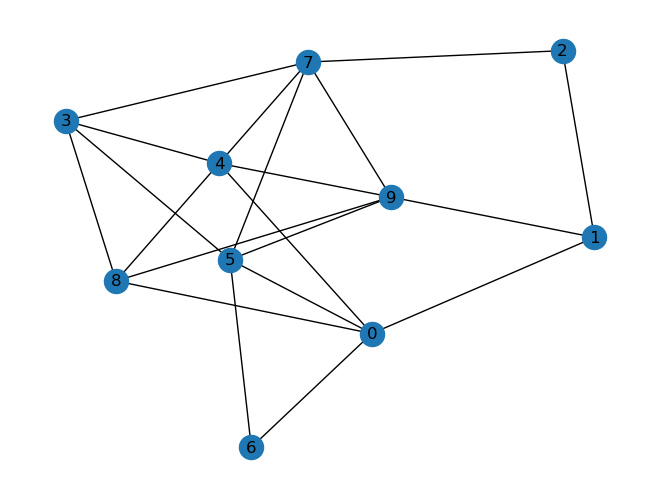

In [6]:
G = nx.gnm_random_graph(10,20)
pos = nx.kamada_kawai_layout(G)
nx.draw(G,pos,with_labels = True)

# Isomorphisms

I have two networks, G and G' with the same number of nodes. I can map each node in G to a node in G' using a mapping function $f(v_G) = v_{G'}$.

Let $v \in N(u)$ denote that $v$ is in the neighbourhood of $u$

I can say a mapping $f(\cdot)$ is an isomorphism, if and only if, for every pair of adjacent nodes $v \in N(u)$ we also have $f(v)$ in $N(f(u))$

[2, 12, 22, 32, 42, 52, 62, 72, 82, 92]


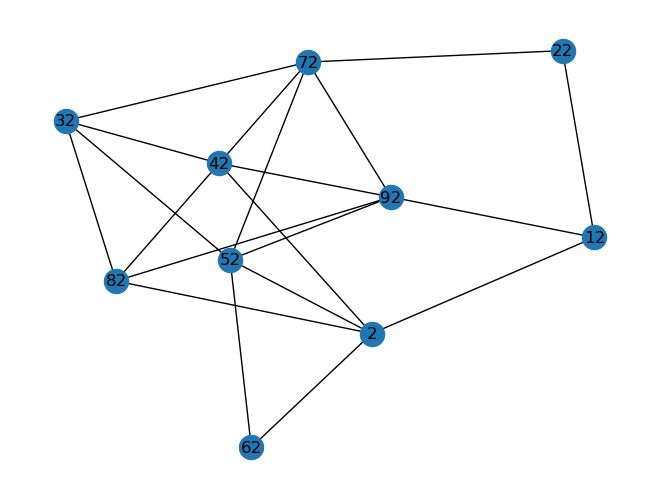

In [17]:
H = nx.Graph()
def map_nodes(G,H):
    Hnodes = []
    for node in G.nodes():
        
        new_node = node*10 +2
        Hnodes.append(new_node)

    H.add_nodes_from(Hnodes)
    print(H.nodes())


def map_edges(G,H):
    Hedges = []
    for edge in G.edges():
        new_edge = (edge[0]*10 +2 , edge[1]*10 +2)
        Hedges.append(new_edge)
    H.add_edges_from(Hedges)
map_nodes(G,H)
map_edges(G,H)
pos = nx.kamada_kawai_layout(H)
nx.draw(H,pos,with_labels = True)



# GNNs and the W-L isomorphism test

The first message-passing based graph representation, was used as an isomorphism test.


![alt text](165729.png)

In [23]:
print(nx.weisfeiler_lehman_graph_hash(G))
print(nx.weisfeiler_lehman_graph_hash(H))

6cfbc7752b15ff57eca90c6d631eb40c
6cfbc7752b15ff57eca90c6d631eb40c


# Message passing as a means of learning global structures

There are two stages of message passing: 

1) Determining the neighbourhood $N(u)$
2) How do we aggregate information from the neighbourhood

There is a third stage, after message passing, which is to map the resulting aggregated messages to an embedded space using nonlinear activation functions.

$h_u = \sigma(W_1 x_u + W_2 . AGG(x_v)_{v \in N(u)})$ (This is GraphSage)

Message aggregation $AGG(.)$ can be any permutation-invariant function

 

# Trouble in paradise

It does not always work, and it inherets the same limitations as the WL test. Famously, one layer of a GNN can not distinguish between basic structures. That is to say, the represenations come out identical.

If two distinct nodes have identical node features (say the node features are the degrees, or in the case of WL node colour), their effect on the $AGG(.)$ function will be the same...

Case in point, it can't distinguish to cycles of 3 nodes, from one cyle of 6 nodes if the node fea

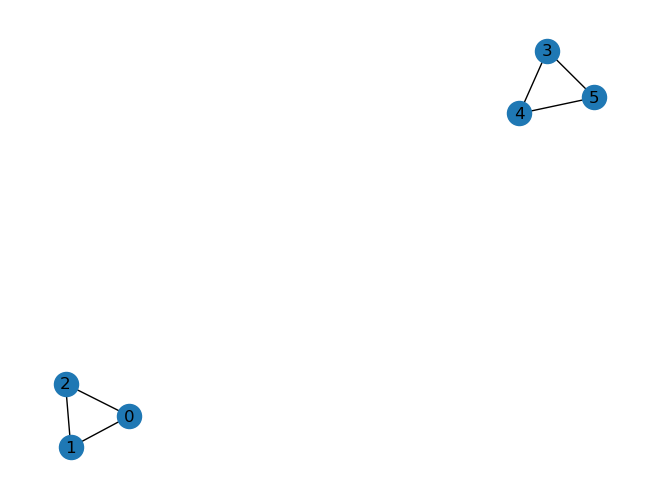

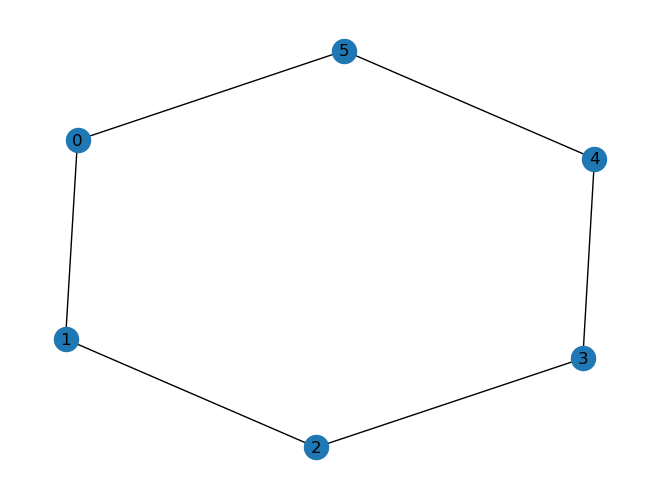

In [37]:
H = nx.Graph()
H.add_edges_from([(0,1),(1,2),(2,0), (3,4),(4,5),(5,3)])
nx.draw(H,with_labels = True)
plt.show()

H1 = nx.Graph()
H1.add_edges_from([(0,1),(1,2),(2,3), (3,4),(4,5),(5,0)])
nx.draw(H1,with_labels = True)

In [38]:
print(nx.weisfeiler_lehman_graph_hash(H1))
print(nx.weisfeiler_lehman_graph_hash(H))

da3c81488557dc57e6e1f0bd43d65336
da3c81488557dc57e6e1f0bd43d65336


# Even more trouble in paradise

They are prone to oversmoothing: too many layers, in the absence of the attention mechanism, this leads toleads to the same information being aggregated for all nodes.  



Prone to oversquashing: aggregation functions, in their most cases, get $n$ vectors of length $l$ into one vector of length $l$. By its nature, this can lead to loss of information.


Bottlenecks: If you have disconnected components, they can not share messages.
 

# So what can we do?

A lot of effort went into moving" beyond message passing" (google this phrase, you will see the papers)

The 2022 paper, "message passing all the way up", argues that all of these contributions are in essence augmenting the message passing process.

Nonetheless, they lead to significant improvements to the final performance.

Here are the a few ideas to consider/improve the GNNs we use, mostly from the same paper:

1) Do I need a GNN for this task? Typically, if the only thing you have to work with is the graph topology, then there might be a centrality measure that can help




[0.17106481 0.07361111 0.01736111 0.03101852 0.0587963  0.1412037
 0.         0.14861111 0.03009259 0.10601852]


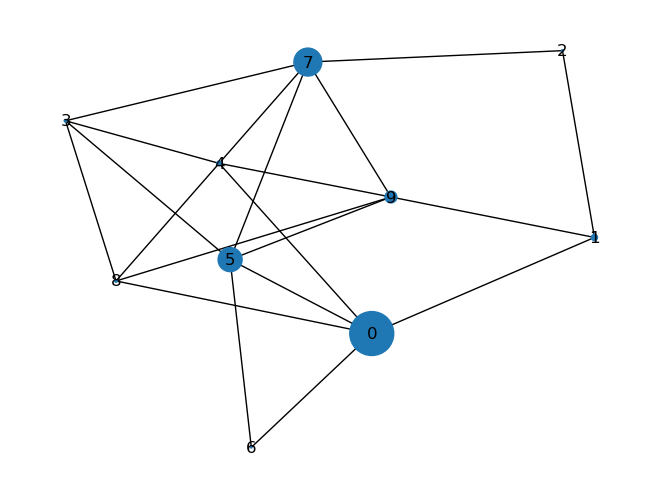

In [39]:
# %%
def plot_centrality(G, centrality):
    valid_cents = {'eig':nx.eigenvector_centrality_numpy, 
                   'btwns':nx.betweenness_centrality, 
                   'katz': nx.katz_centrality_numpy, 
                   'PageRank':nx.pagerank,
                   'closeness': nx.closeness_centrality,
                   'cfc':nx.current_flow_closeness_centrality,
                   'laplace':nx.laplacian_centrality}
    cents = np.array(list(valid_cents[centrality](G).values()))
    print(cents)
    cents_normalised = cents/max(cents)
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G,pos,node_size = np.power(10,3*cents_normalised), with_labels = True )
    plt.show()

plot_centrality(G,'btwns')

[0.33454295 0.19439648 0.1298431  0.33842029 0.40434322 0.36426814
 0.16030939 0.37160775 0.3350023  0.38301543]


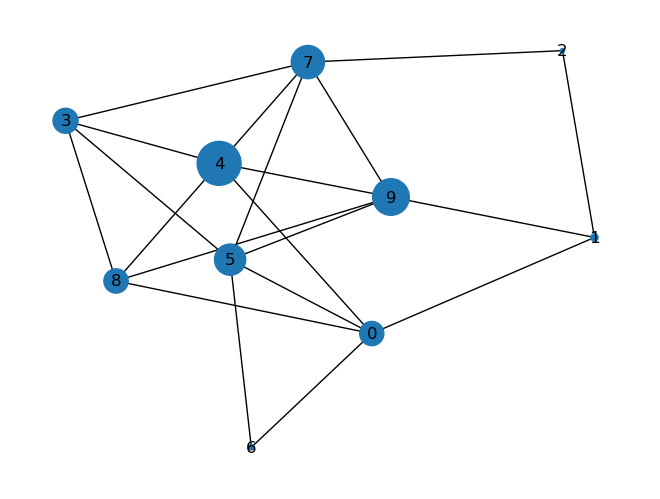

In [40]:
plot_centrality(G,'eig')

# Informative node features: 


Adding node features that are unique to each node (e.g. a one-hot encoding) can improve the GNN's capability in detecting stcurctures (e.g. cycles)


Importantly, these features can be any feature that the GNN will probably struggle to extract on it's own.



# Message Passing modulation

Explicit use of certain node features. Moreover, once initiated, these can be learnable in nature. For example:

using the laplacian eigenvectors for the positional encoding $p$ of each node, then updating the node features $h$ as follows:

$h_u = \sigma(W_1 [x_u,p_u] + W_2 . AGG([x_v,p_v])_{v \in N(u)})$

$p_u = \sigma(W_3 [p_u] + W_4 . AGG([p_v])_{v \in N(u)})$

allows for direct use of positional information to propagate through. (Dwidvedi 2022)


# Recreating the graph:

Adding of imaginary edges (aka graph rewiring) and nodes (e.g. adding a node that represents a substructure). For example, graph transformers, where they imagine the graph to be fully connected. This is essentially ignoring the graph structure, in the hopes of making it more suitable for existing hardware.

Another important example is multihop layers, which have existed for a long time, which may prove more useful in communications.

An exampe of adding nodes, is to add a node to the graph that represents a cycle in the graph, then you can model the graph of relations between the nodes.








